<a href="https://colab.research.google.com/github/fxrdhan/Bike-Sharing-Demand-Prediction/blob/main/UCI_Bike_Sharing_Linear_Regression_FINAL_(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PREDIKSI JUMLAH PENYEWA SEPEDA HARIAN MENGGUNAKAN REGRESI LINEAR BERGANDA**

Dataset: **UCI Bike Sharing Dataset** (day-level) — https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset


**Kelompok**: 1

**Nama / NIM**:

1. Firdaus Arif Ramadhani / 101032300131
2. Muhammad Fakhri Arrasyid / 101032300150
3. Yoga Reswara / 101032300119

**Kelas**:  TK-47-04

**Dosen Pengampu**: Dr. Budhi Irawan, S.Si., M.T

**Tahun / Semester**: 2025 / 5



## **BAB III — METODOLOGI PENELITIAN**

### **3.1 Alur Penelitian**
Pengembangan model prediksi ini dilakukan dengan tahapan yang terintegrasi dalam sebuah pipeline agar hasil penelitian dapat direproduksi kembali. Tahapan dimulai dari akuisisi data mentah, pembersihan, hingga evaluasi performa model.

Alur kerja dimulai dengan pemuatan data dari UCI Repository, dilanjutkan dengan validasi struktur data. Berhubung sifat data yang kronologis, pembagian data dilakukan berbasis waktu untuk mencegah kebocoran informasi masa depan. Proses pra-pemrosesan mencakup transformasi fitur kategorikal dan numerik sebelum akhirnya dilakukan pelatihan menggunakan algoritma Regresi Linear Berganda.

### **3.2 Dataset**
Penelitian ini memanfaatkan *UCI Bike Sharing Dataset* pada level harian sebanyak 731 baris data. Variabel target yang diprediksi adalah `cnt` (total peminjaman harian). Fitur-fitur pendukung mencakup variabel kalender (musim, bulan, hari kerja) serta variabel cuaca (suhu, kelembapan, dan kecepatan angin) yang diperkirakan memengaruhi perilaku penyewa sepeda.

### **3.3 Pra-pemrosesan Data**
Tahapan ini bertujuan untuk menyiapkan data agar dapat diterima oleh model:

1. Data dibagi secara kronologis dengan proporsi 80% untuk pelatihan dan 20% untuk pengujian.
2. Fitur kategorikal diolah menggunakan One-Hot Encoding untuk menghindari asumsi urutan (ordinality), sementara fitur numerik dilakukan penskalaan menggunakan StandardScaler agar seluruh variabel berada pada rentang nilai yang setara.

### **3.4 Perancangan Sistem**
Pembangunan sistem prediksi dalam penelitian ini dirancang menggunakan kerangka kerja pipeline dari pustaka scikit-learn. Pendekatan ini dipilih untuk menjamin seluruh tahapan, mulai dari transformasi data hingga proses inferensi model, berjalan secara  konsisten guna meminimalkan risiko kesalahan serta memudahkan reproduksi hasil penelitian.

Adapun spesifikasi perancangan sistem adalah sebagai berikut:

1. Input: Fitur-fitur yang digunakan mencakup variabel temporal (musim, bulan, hari libur, dll.) dan variabel lingkungan (suhu, kelembapan, kecepatan angin). Sebelum masuk ke tahap pelatihan, dilakukan eliminasi terhadap kolom dteday dan fitur-fitur yang berpotensi menyebabkan kebocoran data (data leakage).

2. Output: Variabel target berupa nilai numerik kontinu yang mempresentasikan estimasi jumlah penyewa sepeda harian (cnt).

3. Arsitektur Model: Arsitektur sistem disusun dengan urutan ColumnTransformer (meliputi proses One-Hot Encoding dan Standard Scaling) yang kemudian dihubungkan langsung dengan algoritma Linear Regression (metode Ordinary Least Squares) sebagai model baseline utama.
Kriteria keberhasilan: performa pada data test lebih baik daripada baseline sederhana (prediksi rata-rata train) dan error (RMSE/MAE) masih dapat diterima untuk estimasi permintaan harian.

Model dianggap berhasil apabila mampu menunjukkan performa generalisasi pada data pengujian (test set) yang lebih baik dibandingkan model baseline sederhana (prediksi berbasis nilai rata-rata data latih). Metrik evaluasi difokuskan pada nilai R² untuk mengukur variansi yang tertangkap oleh model, serta RMSE dan MAE untuk memvalidasi besaran galat dalam estimasi harian.

Selain metrik statistik, analisis diagnostik dilakukan melalui plot residual. Keberhasilan model dalam menangkap pola linear ditandai dengan sebaran residual yang acak di sekitar titik nol tanpa menunjukkan tren tertentu. Sebaliknya, jika ditemukan pola berbentuk kipas (funnel shape), hal tersebut mengindikasikan adanya gejala heteroskedastisitas yang lazim ditemui pada data bertipe hitungan (count data), yang selanjutnya akan menjadi dasar dalam pemberian saran pengembangan model pada bab akhir.

## **BAB IV — IMPLEMENTASI DAN PENGUJIAN**

Bab ini memuat lingkungan pengembangan, implementasi pipeline, skenario pengujian, serta hasil dan analisis.

Implementasi dilakukan menggunakan Python dengan pustaka utama: `pandas/numpy` untuk olah data, `scikit-learn` untuk pipeline preprocessing + model, serta `matplotlib` untuk visualisasi.


### **4.1 Lingkungan Pengembangan**

Implementasi sistem dilakukan menggunakan bahasa pemrograman Python 3.12 dengan ekosistem pustaka data sains seperti pandas dan numpy untuk manipulasi data, scikit-learn untuk pemodelan ML, serta matplotlib untuk kebutuhan visualisasi hasil.

In [2]:
import platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

# Library ML (scikit-learn)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# plot style
plt.style.use("seaborn-v0_8")

print("Python:", platform.python_version())
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("scikit-learn:", sklearn.__version__)


Python: 3.12.12
numpy: 2.0.2
pandas: 2.2.2
scikit-learn: 1.6.1


### **4.2 Implementasi Sistem**


#### **4.2.1 Ambil Dataset dari UCI**

In [3]:
import zipfile
import urllib.request

# Download zip file
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip"
urllib.request.urlretrieve(url, "bike_sharing.zip")

# Extract
with zipfile.ZipFile("bike_sharing.zip", 'r') as zip_ref:
    zip_ref.extractall("bike_data")

# Read day.csv
df = pd.read_csv("bike_data/day.csv")

#### **4.2.2 Data Understanding**


Sebelum melakukan pemodelan, dilakukan analisis terhadap struktur dataset. Berdasarkan observasi, kolom casual dan registered merupakan komponen pembentuk target cnt (cnt = casual + registered). Oleh karena itu, fitur-fitur tersebut harus dihapus guna menghindari fenomena data leakage yang dapat menyebabkan akurasi model menjadi tidak valid.

In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


- Target: `cnt`
- `dteday` dipakai untuk urutan waktu (split), lalu di-drop sebelum training
- Kolom `casual` dan `registered` adalah komponen pembentuk `cnt` (`cnt = casual + registered`) sehingga **tidak boleh** dipakai sebagai fitur (mencegah *data leakage*)
- Kolom `instant` hanya ID baris, sehingga tidak dipakai sebagai fitur

In [5]:
# Cek data hilang
df.isna().sum()

,0
instant,0
dteday,0
season,0
yr,0
mnth,0
holiday,0
weekday,0
workingday,0
weathersit,0
temp,0


In [6]:
# Cek duplikasi baris
df.duplicated().sum()

np.int64(0)

#### **4.2.3 Split Data Berbasis Waktu**

Jangan *random split* karena data bersifat time-series.

Kita pakai *holdout* berbasis waktu yang sederhana:
- Urutkan data berdasarkan `dteday`
- Train: 80% data awal
- Test : 20% data akhir

Catatan: dataset memuat rentang 2011–2012, jadi split ini biasanya membuat train mencakup 2011 sampai sebagian 2012, lalu test di akhir 2012.


In [7]:
df["dteday"] = pd.to_datetime(df["dteday"], errors="coerce")
df = df.sort_values("dteday").reset_index(drop=True)

split_idx = int(len(df) * 0.8)
train_df = df.iloc[:split_idx].copy()
test_df = df.iloc[split_idx:].copy()

# Drop kolom yang tidak dipakai sebagai fitur (anti-leakage + kolom ID)
drop_cols = ["cnt", "dteday", "instant", "casual", "registered"]
X_train = train_df.drop(columns=drop_cols)
y_train = train_df["cnt"]

X_test = test_df.drop(columns=drop_cols)
y_test = test_df["cnt"]

{
    'X_train': X_train.shape,
    'X_test': X_test.shape,
    'train_range': (train_df['dteday'].min().date(), train_df['dteday'].max().date()),
    'test_range': (test_df['dteday'].min().date(), test_df['dteday'].max().date()),
}


{'X_train': (584, 11),
 'X_test': (147, 11),
 'train_range': (datetime.date(2011, 1, 1), datetime.date(2012, 8, 6)),
 'test_range': (datetime.date(2012, 8, 7), datetime.date(2012, 12, 31))}

#### **4.2.4 EDA**

EDA sederhana berikut dibuat untuk melihat distribusi target dan indikasi pola musiman/cuaca.


**(1) Distribusi `cnt` (histogram)**

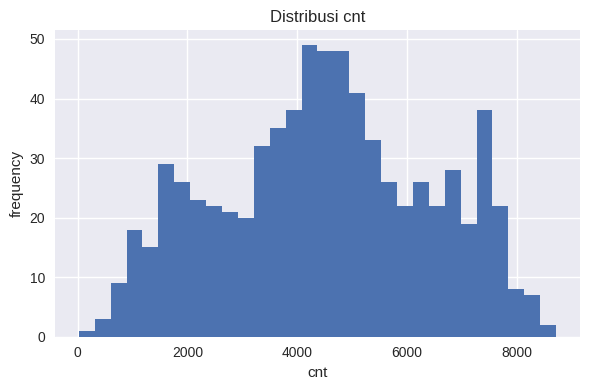

In [8]:
plt.figure(figsize=(6, 4))
df["cnt"].hist(bins=30)
plt.title("Distribusi cnt")
plt.xlabel("cnt")
plt.ylabel("frequency")
plt.tight_layout()
plt.show()


- Sebaran `cnt` cenderung miring ke kanan: mayoritas hari berada pada peminjaman menengah, sementara hari dengan peminjaman sangat tinggi lebih sedikit.
- Kuartil memberi gambaran skala target: Q1 ≈ 3152, median ≈ 4548, Q3 ≈ 5956, dan nilai tinggi bisa mencapai > 8000.
- Target berbentuk hitungan dengan ekor panjang seperti ini sering membuat error pada permintaan tinggi lebih besar, sehingga RMSE menjadi metrik penting.

**(2) Korelasi cuaca vs `cnt` (numerik)**

In [9]:
num_cols_simple = ["temp", "atemp", "hum", "windspeed"]
df[num_cols_simple + ["cnt"]].corr()


,temp,atemp,hum,windspeed,cnt
temp,1.000000,0.991702,0.126963,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.100659
windspeed,-0.157944,-0.183643,-0.248489,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,1.000000


- `temp` dan `atemp` berkorelasi positif cukup kuat terhadap `cnt` (≈ 0.63), artinya hari yang lebih hangat cenderung lebih ramai.
- `windspeed` berkorelasi negatif (≈ -0.23) dan `hum` cenderung negatif lemah (≈ -0.10), mengindikasikan angin/kelembapan tinggi dapat menekan peminjaman.
- Karena `temp` dan `atemp` juga sangat berkorelasi satu sama lain, koefisien keduanya bisa kurang stabil (alasan saran Ridge/Lasso di BAB V).

**(3) Pola musiman (bulan & season)**

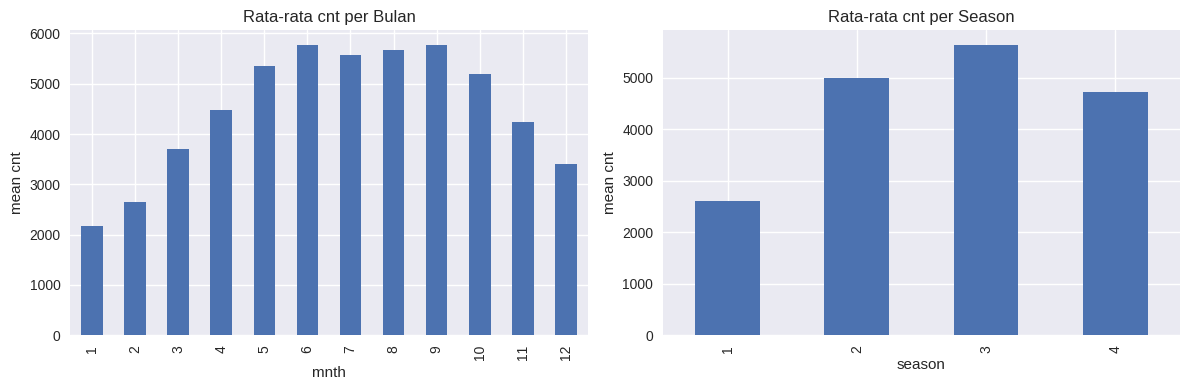

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
df.groupby("mnth")["cnt"].mean().plot(kind="bar", ax=ax[0], title="Rata-rata cnt per Bulan")
ax[0].set_xlabel("mnth")
ax[0].set_ylabel("mean cnt")

df.groupby("season")["cnt"].mean().plot(kind="bar", ax=ax[1], title="Rata-rata cnt per Season")
ax[1].set_xlabel("season")
ax[1].set_ylabel("mean cnt")

plt.tight_layout()
plt.show()

- Rata-rata `cnt` per bulan menunjukkan musim ramai di pertengahan tahun; bulan 6/9/8 termasuk yang tertinggi, sedangkan bulan 1/2 cenderung terendah.
- Per `season`, kategori 3 (fall) memiliki rata-rata paling tinggi dan kategori 1 (spring) paling rendah pada data ini.
- Temuan ini mendukung penggunaan fitur kalender (`mnth`, `season`, `weekday`, dll.) sebagai fitur kategorikal pada model.

#### **4.2.5 Preprocessing Pipeline (One-hot + Scaling)**

- Kategorikal (one-hot): `season, mnth, weekday, weathersit, holiday, workingday, yr`
- Numerik (scaling): `temp, atemp, hum, windspeed`
- `remainder="drop"`: kolom lain yang tidak disebutkan tidak ikut training


In [11]:
cat_cols = ["season", "mnth", "weekday", "weathersit", "holiday", "workingday", "yr"]
num_cols = ["temp", "atemp", "hum", "windspeed"]

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop",
)

#### **4.2.6 Model Baseline: Linear Regression**

In [12]:
model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("lr", LinearRegression()),
])

model.fit(X_train, y_train)

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

### **4.3 Skenario Pengujian**

Pengujian dilakukan untuk mengukur kemampuan generalisasi model pada data masa depan (simulasi kondisi nyata).

**Skenario pengujian**
- Holdout berbasis waktu: 80% awal (train) dan 20% akhir (test)
- Metrik: R², RMSE, MAE
- Baseline pembanding: prediksi rata-rata `cnt` pada data train
- Diagnostik: plot actual vs predicted, residual vs predicted, dan distribusi residual


#### **4.3.1 Evaluasi (R², RMSE, MAE)**

Selain model linear, kita tambahkan pembanding sederhana: **baseline** yang selalu memprediksi rata-rata `cnt` pada data train.


In [13]:
def regression_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mae = mean_absolute_error(y_true, y_pred)
    return r2, rmse, mae

r2_tr, rmse_tr, mae_tr = regression_metrics(y_train, pred_train)
r2_te, rmse_te, mae_te = regression_metrics(y_test, pred_test)

print(f"TRAIN  R2: {r2_tr:.4f} | RMSE: {rmse_tr:.2f} | MAE: {mae_tr:.2f}")
print(f"TEST   R2: {r2_te:.4f} | RMSE: {rmse_te:.2f} | MAE: {mae_te:.2f}")


TRAIN  R2: 0.8557 | RMSE: 678.94 | MAE: 506.04
TEST   R2: 0.6540 | RMSE: 1102.66 | MAE: 803.63


#### **4.3.2 Baseline Pembanding (Prediksi Rata-rata)**

Baseline ini selalu memprediksi nilai konstan, yaitu **rata-rata `cnt` pada data train**.
Jika R² baseline bernilai negatif, artinya prediksi konstan tersebut lebih buruk daripada hanya menggunakan rata-rata `cnt` pada data test, sehingga pola musiman/cuaca memang penting untuk dipelajari model.


In [14]:
baseline_pred = np.repeat(y_train.mean(), len(y_test))
r2_b, rmse_b, mae_b = regression_metrics(y_test, baseline_pred)

print(f"BASELINE TEST R2: {r2_b:.4f} | RMSE: {rmse_b:.2f} | MAE: {mae_b:.2f}")

BASELINE TEST R2: -0.8657 | RMSE: 2560.56 | MAE: 2290.41


### **4.4 Hasil dan Analisis**

#### **4.4.1 Ringkasan Hasil Pengujian (Tabel Metrik)**

Tabel berikut merangkum metrik train/test serta baseline pada data test.


In [15]:
metrics_df = pd.DataFrame(
    {
        "split": ["train", "test", "baseline_test"],
        "r2": [r2_tr, r2_te, r2_b],
        "rmse": [rmse_tr, rmse_te, rmse_b],
        "mae": [mae_tr, mae_te, mae_b],
    }
).set_index("split")

metrics_df.round(4)

,r2,rmse,mae
split,,,
train,0.8557,678.9432,506.0428
test,0.6540,1102.6622,803.6255
baseline_test,-0.8657,2560.5558,2290.4127


Berdasarkan hasil pengujian pada Tabel [Nomor Tabel], model Regresi Linear Berganda menunjukkan performa yang cukup signifikan dibandingkan model baseline (prediksi nilai rata-rata). Meskipun terdapat penurunan nilai R² dari data train (0.85) ke data test (0.65), model ini tetap mampu menangkap pola umum permintaan sepeda berdasarkan variabel cuaca dan waktu. Penurunan performa ini mengindikasikan adanya hubungan non-linear yang belum sepenuhnya terakomodasi oleh model linear sederhana.

#### **4.4.2 Analisis dan Plot Aktual vs Prediksi**

Berdasarkan Tabel metrik di atas, model **Linear Regression** mampu mengalahkan baseline sederhana (prediksi rata-rata) pada data *test*.
Nilai R² pada *train* yang lebih tinggi dibanding *test* menunjukkan masih ada pola (mis. musiman/non-linear ringan) yang belum sepenuhnya tertangkap oleh model linear baseline, namun performanya sudah memadai sebagai pendekatan yang **mudah diimplementasikan** dan **mudah diinterpretasikan**.

Plot berikut memperlihatkan perbandingan nilai aktual (`cnt`) dan prediksi pada data *test*. Titik yang semakin dekat dengan garis diagonal menandakan prediksi semakin akurat.


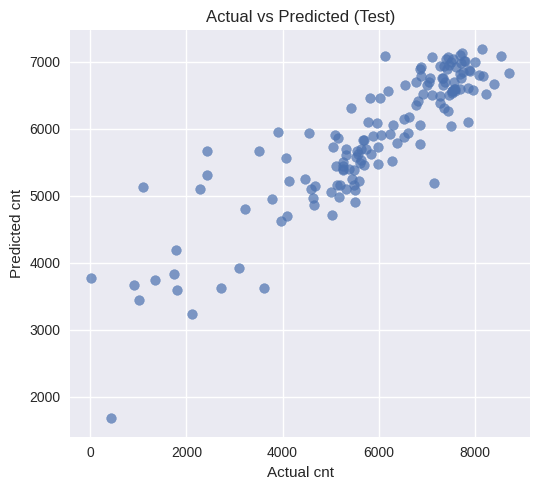

In [16]:
plt.figure(figsize=(5.5, 5))
plt.scatter(y_test, pred_test, alpha=0.7)
plt.xlabel("Actual cnt")
plt.ylabel("Predicted cnt")
plt.title("Actual vs Predicted (Test)")
plt.tight_layout()
plt.show()


#### **4.4.3 Diagnostik Residual**

**(1) Residual vs Predicted (indikasi heteroskedastisitas)**

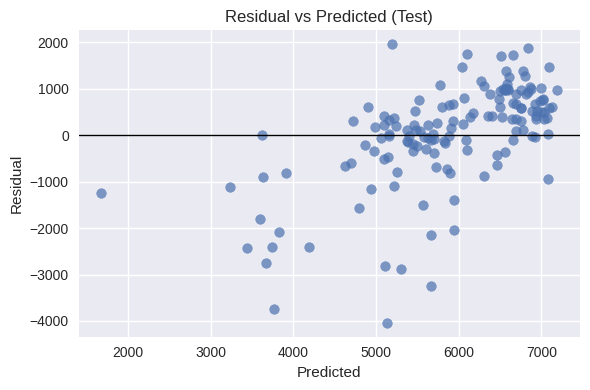

In [20]:
resid = y_test - pred_test

plt.figure(figsize=(6, 4))
plt.scatter(pred_test, resid, alpha=0.7)
plt.axhline(0, color="black", linewidth=1)
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.title("Residual vs Predicted (Test)")
plt.tight_layout()
plt.show()

**(2) Histogram residual (bentuk sebaran)**

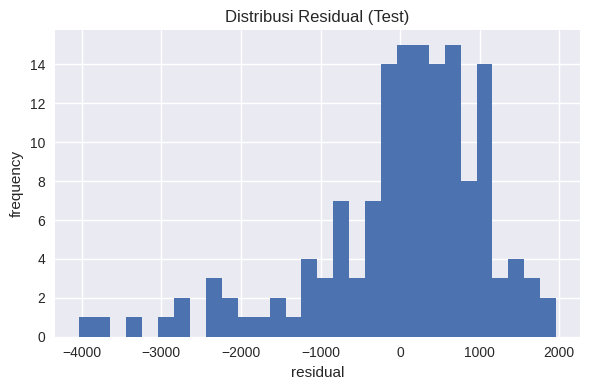

Residual mean: 20.16 | std: 1106.25 | skew: -1.31
Outlier |resid| > 3σ: 2 | corr(|resid|, pred): -0.252


In [19]:
plt.figure(figsize=(6, 4))
pd.Series(resid).hist(bins=30)
plt.title("Distribusi Residual (Test)")
plt.xlabel("residual")
plt.ylabel("frequency")
plt.tight_layout()
plt.show()

# Ringkasan statistik residual
resid_s = pd.Series(resid)
outlier_3sigma = int((resid_s.abs() > 3 * resid_s.std()).sum())
corr_abs = float(np.corrcoef(np.abs(resid), pred_test)[0, 1])
print(f"Residual mean: {resid_s.mean():.2f} | std: {resid_s.std():.2f} | skew: {resid_s.skew():.2f}")
print(f"Outlier |resid| > 3σ: {outlier_3sigma} | corr(|resid|, pred): {corr_abs:.3f}")


Kesimpulan singkat (berdasarkan plot + statistik):
- Rata-rata residual mendekati 0 → model tidak bias secara sistematis pada data test.
- Ada beberapa residual ekstrem (outlier), sehingga sebaran residual tidak sepenuhnya normal.
- Penyebaran residual tidak menunjukkan pola yang sangat kuat; jika terlihat pola kipas, pertimbangkan regularisasi atau model non-linear ringan.

#### **4.4.4 Interpretasi Koefisien**

Catatan interpretasi:
- Fitur numerik memakai `StandardScaler` → koefisien = perubahan `cnt` untuk kenaikan **1 standar deviasi** fitur.
- Fitur kategorikal memakai one-hot `drop="first"` → koefisien = selisih terhadap **kategori baseline** (yang di-drop).

Ringkasan koefisien terbesar (berdasarkan hasil training):
- **Top 3 positif**: `yr_1` (≈ +2040), `mnth_9` (≈ +1373), `mnth_5` (≈ +1192).
- **Top 3 negatif**: `weathersit_3` (≈ -1714), `weathersit_2` (≈ -389), `hum` (≈ -195 per 1 SD).

Interpretasi singkat: tahun 2012 (`yr_1`) cenderung memiliki `cnt` lebih tinggi dibanding 2011 (baseline), sedangkan bulan-bulan tertentu (mis. 9 dan 5) lebih ramai dibanding bulan baseline (Januari). Di sisi lain, cuaca yang lebih buruk (`weathersit_2/3`) menurunkan peminjaman relatif cuaca cerah, dan kelembapan yang lebih tinggi (`hum`) juga menekan jumlah peminjaman.


In [18]:
# Lihat kategori baseline (yang di-drop) untuk tiap fitur kategorikal
ohe = model.named_steps["preprocess"].named_transformers_["cat"]
baseline_category = {col: cats[0] for col, cats in zip(cat_cols, ohe.categories_)}
print("Baseline category (yang di-drop):")
for col, base in baseline_category.items():
    print(f"- {col}: {base}")

# Ambil nama fitur hasil preprocessing + koefisien model
feature_names = model.named_steps["preprocess"].get_feature_names_out()
feature_names = [name.replace("num__", "").replace("cat__", "") for name in feature_names]
coefs = model.named_steps["lr"].coef_

coef_df = (
    pd.DataFrame({"feature": feature_names, "coef": coefs})
    .sort_values("coef", ascending=False)
    .reset_index(drop=True)
)

print("\nTop 3 koefisien positif:")
print(coef_df.head(3).to_string(index=False))
print("\nTop 3 koefisien negatif:")
print(coef_df.tail(3).sort_values("coef").to_string(index=False))

coef_df.head(15)


Baseline category (yang di-drop):
- season: 1
- mnth: 1
- weekday: 0
- weathersit: 1
- holiday: 0
- workingday: 0
- yr: 0

Top 3 koefisien positif:
feature        coef
   yr_1 2039.968257
 mnth_9 1372.899732
 mnth_5 1191.631366

Top 3 koefisien negatif:
     feature         coef
weathersit_3 -1714.401235
weathersit_2  -389.274224
         hum  -194.830150


,feature,coef
0,yr_1,2039.968257
1,mnth_9,1372.899732
2,mnth_5,1191.631366
3,mnth_6,1135.744218
4,mnth_10,1085.712641
5,season_4,1044.358358
6,mnth_8,959.002731
7,mnth_4,801.920477
8,mnth_7,758.038818
9,mnth_3,730.516346


## **BAB V — PENUTUP**

### **5.1 Kesimpulan**
- Model baseline **Linear Regression** dengan preprocessing (scaling fitur numerik + *one-hot encoding* fitur kategorikal) berhasil digunakan untuk memprediksi jumlah peminjaman sepeda harian (`cnt`).
- Pada data *test* (20% bagian akhir), model mencapai performa yang memadai sebagai baseline: **R² ≈ 0.65**, **RMSE ≈ 1102.66**, dan **MAE ≈ 803.63** (lihat Tabel metrik pada Bagian 4.4.1).
- Dibanding baseline sederhana (prediksi rata-rata `cnt` pada data *train*), model memberikan peningkatan performa yang jelas.
- Diagnostik residual dan interpretasi koefisien menunjukkan faktor terkait **cuaca** dan **kalender/musim** berkontribusi terhadap variasi `cnt`.

### **5.2 Saran**
- Coba **Ridge/Lasso (regularisasi)** untuk mengurangi dampak multikolinearitas dan membuat koefisien lebih stabil.
- Karena `temp` dan `atemp` sangat berkorelasi, pertimbangkan **menghapus salah satu** lalu bandingkan metrik.
- Tambahkan perluasan yang masih “linear” seperti **PolynomialFeatures (derajat 2)** untuk menangkap non-linear ringan.
- Lakukan *feature engineering* sederhana yang relevan (mis. interaksi musim–cuaca, atau fitur tren waktu) bila konteks penggunaan membutuhkan.


## **DAFTAR PUSTAKA**

1. Fanaee-T, H., & Gama, J. **Bike Sharing Dataset**. UCI Machine Learning Repository. https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset
2. scikit-learn Documentation: **LinearRegression**, **Pipeline**, **ColumnTransformer**, **OneHotEncoder**, **StandardScaler**. https://scikit-learn.org/stable/
3. James, G., Witten, D., Hastie, T., & Tibshirani, R. *An Introduction to Statistical Learning* (bab Regresi Linear).
